# Submission 1, ML Assignment 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [2]:
amazon = pd.read_csv('/Users/working/Documents/ParsonsSchool/Sp19/MachineLearning/DATASET/amazon_data/raw_data_test.csv')
print(amazon.shape)

(91000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      207103        112082  112083  B002Y2QT2K  A22Y5TJPN98DWB   
1      139933        224640  224641  B009D53XKC  A3MDY6Y3Z6D649   
2       76100        399707  399708  B005GIF5WY  A3LCQXQ4SFYBAU   
3      114178        567900  567901  B005K4Q68Q  A2E65ZXD654761   
4      285272        263134  263135  B002WW3BW8  A1XAZ0MR4TRY16   

                  ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                Eva Juergens                     1                       1   
1  The Man Behind the Curtain                     1                       1   
2                  Johna Jane                     0                       0   
3                   Barbara L                     0                       0   
4                        bfn1                     0                       0   

   Score        Time                          Summary  \
0      3  1339286400                 chicory "coffee"   
1      5

### Feature extraction on natural language data

In [4]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [5]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 131072)


In [6]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [7]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [8]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      3        116
1      5       2915
2      5        152
3      5        167
4      3        120
5      1        193
6      5        732
7      5       1122
8      5         88
9      5        549
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [9]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 131074)


### Create `X`, scaled matrix of features

In [10]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 131074)


### create `y`, vector of Labels

In [11]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [15]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 936, 'TN': 82961, 'FP': 1432, 'FN': 5671, 'Accuracy': 0.921945054945055, 'Precision': 0.3952702702702703, 'Recall': 0.14166792795519903, 'desc': 'rdg'}


In [16]:
# MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
lgs = joblib.load('lgs.pkl')

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 1770, 'TN': 78897, 'FP': 5496, 'FN': 4837, 'Accuracy': 0.8864505494505495, 'Precision': 0.24360033030553263, 'Recall': 0.2678976842742546, 'desc': 'lgs'}


### ROC plot to compare performance of various models and fits

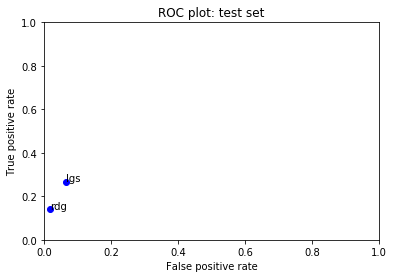

In [17]:
fits = [rdg_performance,lgs_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()